In [1]:
import json
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from data.graph_loader import load_graph
%matplotlib inline

print(f'Loading ratings')
mr = pd.read_csv('../data/mindreader/ratings.csv')

# Remove unknown ratings
mr = mr[mr.sentiment != 0]

# Load entities
entity_labels = dict()
entity_names = dict()
with open('../data/mindreader/entities_clean.json', 'r') as file:
    data = json.load(file)
    
    for uri, name, labels in data:
        entity_labels[uri] = set(labels.split('|'))
        entity_names[uri] = name

# Load NX graph
print(f'Loading graph')
g = load_graph('../data/graph/triples.csv', directed=True)

Loading ratings
Loading graph


In [2]:
def _propagate(node, preferences, preference):
    for neighbor in g.neighbors(node):
        preferences[neighbor].append(preference)
        
        # _propagate(neighbor, preferences, preference * 0.5)
            

def propagate(movie_preferences):
    preferences = defaultdict(list)
    
    for movie, preference in movie_preferences.items():
        _propagate(movie, preferences, preference)
            
    return preferences


def reduce_preferences(preferences):
    reduced = dict()
    
    # Reduces preferences from a list of ratings to its majority vote
    for uri, preference_list in preferences.items():
        mean = np.mean(preference_list)
        variance = np.var(preference_list)
        
        prediction = 0 if mean == 0. or variance > 0.85 else 1 if mean > 0 else -1
        if prediction:
            reduced[uri] = prediction
    
    return reduced


def infer_preferences(ratings, user):
    user_ratings = ratings[ratings.userId == user][['uri', 'sentiment', 'isItem']]
    entity_preferences = dict()
    movie_preferences = dict()
    
    for idx, row in user_ratings[user_ratings.isItem].iterrows():
        movie_preferences[row['uri']] = row['sentiment']
        
    for idx, row in user_ratings[~user_ratings.isItem].iterrows():
        entity_preferences[row['uri']] = row['sentiment']
    
    return reduce_preferences(propagate(movie_preferences)), entity_preferences


def predict(user, uris=None):
    predicted, actual = infer_preferences(mr, user)
    overlapping = set(predicted.keys()).intersection(set(actual.keys()))
    wrong_classifications = {key: defaultdict(int) for key in [-1, 1]}
    tp, fp, tn, fn = [0 for _ in range(4)]

    for key in overlapping:
        if uris and key not in uris:
            continue
        
        if actual[key] == 1 and predicted[key] == 1:
            tp += 1
        elif actual[key] == -1 and predicted[key] == 1:
            fp += 1
        elif actual[key] == -1 and predicted[key] == -1:
            tn += 1
        elif actual[key] == 1 and predicted[key] == -1:
            fn += 1
            
        # Add to wrong classifications
        if actual[key] != predicted[key]:
            wrong_classifications[predicted[key]][key] += 1
    
    return tp, fp, tn, fn, wrong_classifications


def get_metrics(df, uris=None):
    users = df.userId.unique()
    total_tp, total_fp, total_tn, total_fn = [0 for _ in range(4)]
    wrong_classifications = {key: defaultdict(int) for key in [-1, 1]}
    
    for user in tqdm(users):
        tp, fp, tn, fn, wrong = predict(user, uris=uris)
        
        total_tp += tp
        total_fp += fp
        total_tn += tn
        total_fn += fn
        
        # Add wrong classifications
        for key, predictions in wrong.items():
            for  k, v in predictions.items():
                wrong_classifications[key][k] += v
    
    precision = total_tp / (total_tp + total_fp)
    sensitivity = total_tp / (total_tp + total_fn)
    specificity = total_tn / (total_tn + total_fp)
    accuracy = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn)
    f1 = (2 * precision * sensitivity) / (precision + sensitivity)
    
    return precision, sensitivity, specificity, f1, accuracy, wrong_classifications


def print_metrics(precision, sensitivity, specificity, f1, accuracy, wrong_classifications):
    print(f'Precision: {precision * 100}%')
    print(f'Sensitivity: {sensitivity * 100}%')
    print(f'Specificity: {specificity * 100}%')
    print(f'F1: {f1 * 100}%')
    print(f'Accuracy: {accuracy * 100}%')
    
    # Print top negative and positive
    for key, label in  {-1: 'negative', 1: 'positive'}.items():
        k = 10
        items = list(wrong_classifications[key].items())
        sum_wrong = sum(item[1] for item in items)
        items = sorted(items, key=lambda item: item[1], reverse=True)[:k]
        
        print(f'Top {k} classified wrongly as {label}:')
        for idx, item in enumerate(items):
            print(f'{idx + 1}. {entity_names[item[0]]} ({item[1] / sum_wrong * 100:.2f}%)')

In [3]:
splits = {
    'All': None,
    'Genre': {'Genre'},
    'Subject': {'Subject'},
    'Person': {'Person'},
    'Studio': {'Company'},
    'Decade': {'Decade'}
}

def get_valid_uris(restrict_to=None):
    if not restrict_to:
        return set(entity_labels.keys())
    
    return {e for e, l in entity_labels.items() if not restrict_to or l.intersection(restrict_to)}

results = dict()
for split, restriction in splits.items():
    results[split] = get_metrics(mr, get_valid_uris(restriction))
    
    print(split)
    print(print_metrics(*results[split]))

100%|██████████| 850/850 [00:17<00:00, 47.77it/s]


All
Precision: 91.4423508299686%
Sensitivity: 82.0716730420777%
Specificity: 63.85599242065372%
F1: 86.50397877984084%
Accuracy: 78.87920298879203%
Top 10 classified wrongly as negative:
1. Movies of the 1990s (4.10%)
2. Movies of the 2000s (3.99%)
3. Movies of the 2010s (3.54%)
4. Comedy Film (2.86%)
5. Action Film (2.70%)
6. Drama Film (2.64%)
7. Science Fiction Film (2.41%)
8. Fantasy Film (2.30%)
9. Thriller Film (2.19%)
10. Warner Bros. (1.97%)
Top 10 classified wrongly as positive:
1. Romantic Comedy (4.46%)
2. Romance Film (4.19%)
3. Action Film (3.28%)
4. Superhero Film (3.01%)
5. Horror Film (2.62%)
6. Drama Film (2.49%)
7. Movies of the 1980s (2.36%)
8. Comedy Film (2.23%)
9. Fantasy Film (2.10%)
10. Movies of the 2010s (1.97%)
None
Genre
Precision: 90.06479481641469%
Sensitivity: 84.58417849898579%
Specificity: 59.21182266009852%
F1: 87.23849372384937%
Accuracy: 79.86060161408656%
Top 10 classified wrongly as negative:
1. Comedy Film (7.46%)
2. Action Film (7.02%)
3. Drama F

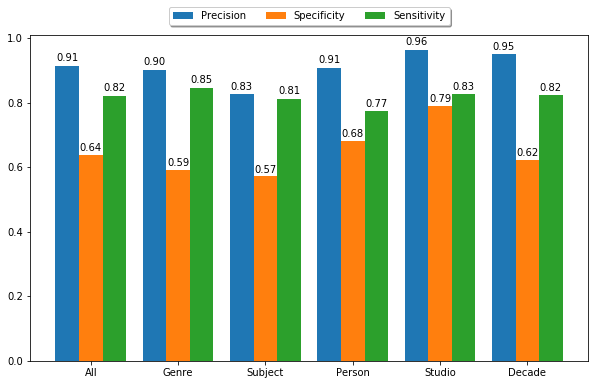

In [4]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

precisions = [metric[0] for metric in results.values()]
sensitivities = [metric[1] for metric in results.values()]
specificities = [metric[2] for metric in results.values()]

width = .27
labels = list(results.keys())
x = np.arange(len(labels))
rects1 = ax.bar(x - width, precisions, width, label='Precision')
rects2 = ax.bar(x, specificities, width, label='Specificity')
rects3 = ax.bar(x + width, sensitivities, width, label='Sensitivity')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, fancybox=True, shadow=True)

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., 1.01*h, f'{h:.2f}',
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.savefig('metrics.png')
plt.show()
